# 1. Utilities

## 1.1 Imports


In [96]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from A2C_boot import A2C
from tqdm import tqdm
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.2 Create Environment


In [97]:
x = torch.tensor([[1,4,1],[0,4,1],[0,1,1]], requires_grad=False)
x = torch.tensor([1,4,1], requires_grad=False)

#find the indices of the values that are equal to 1, it should give 0 and 1
indices =torch.nonzero(x == 1)
print(indices.shape)
print(indices)
print(indices[0].item())
for t in range(indices.shape[0]):
    print(x[indices[t]].item())



torch.Size([2, 1])
tensor([[0],
        [2]])
0
1
1


In [108]:
# environment hyperparams
#option 1 :  use n_updates to define n_steps
n_updates = 100000
n_envs = 1
n_steps_per_update = 5
n_steps = n_envs * n_steps_per_update * n_updates

# agent hyperparams
gamma = 0.99  # discount factor
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 1e-5
critic_lr = 1e-3

# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

# environment setup
#envs = gym.vector.make("CartPole-v1", num_envs=n_envs)
env = gym.make("CartPole-v1")

obs_shape = env.observation_space.shape[0]
print(obs_shape)
action_shape = env.action_space.n
print(action_shape)
# set the device
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

# init the agent
agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)

4
2


In [109]:
# LOGGED VARIABLES
critic_losses = []
actor_losses = []
entropies = []
episode_returns = []
steps_episodes = [] # logs the steps taken in each episode

# COUNTERS
steps = 0
ep_counter = 0
ep_reward = 0

# VARIABLE INITIALIZATION
is_truncated = False
is_terminated = False
states, info = env.reset(seed=42)



# use tqdm to get a progress bar for training
for steps in tqdm(range(n_updates)):
        

    # reset lists that collect experiences of a n_steps_per_update
    n_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
    n_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
    # don't take mask and reward gradient
    masks = torch.ones(n_steps_per_update, n_envs, device=device,requires_grad = False)
    n_rewards = torch.zeros(n_steps_per_update, n_envs, device=device,requires_grad = False)
    end_states = []
    end_states_idx = [0]

    # play n_steps_per_update to collect data
    for step in range(n_steps_per_update):

        # select an action A_{t} using S_{t} as input for the agent, get actions and values Vt
        actions, action_log_probs, V_t, entropy = agent.select_action(states, bool_greedy=False)

        # ensure no grad is taken in the step
        with torch.no_grad():
            # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
            states, reward, is_terminated, is_truncated, infos = env.step(
                actions.cpu().numpy()
            )
            ep_reward += reward # increase episode return
            mask = not is_terminated # define mask for bootstrapping

        # log the value, reward and action log prob of the last step
        n_value_preds[step] = torch.squeeze(V_t)
        n_rewards[step] = torch.tensor(reward, device=device)
        n_action_log_probs[step] = action_log_probs

        # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
        masks[step] = torch.tensor(mask) # allows for correct bootstrapping
        
        # reset environment if truncated or terminated
        if is_terminated or is_truncated:
            states_tensor = torch.tensor(states, device=device) # Transform the last state reached (S_t+n) to a tensor
            end_states.append(states_tensor)
            end_states_idx.append(step)
            states, info = env.reset(seed=42)
            ep_counter += 1
            steps_episodes.append(steps)
            episode_returns.append(ep_reward)
            ep_reward = 0

    
    # if statement to make sure we don't append the end state twice
    if not is_terminated and not is_truncated:
        states_tensor = torch.tensor(states, device=device) # Transform the last state reached (S_t+n) to a tensor
        end_states.append(states_tensor)
        end_states_idx.append(step)
    # calculate the losses for actor and critic
    critic_loss, actor_loss = agent.get_losses(
        n_rewards,
        n_action_log_probs,
        n_value_preds,
        entropy,
        masks,
        gamma,
        end_states,
        end_states_idx
    )

    # update the actor and critic networks
    agent.update_parameters(critic_loss, actor_loss)

    # log the losses and entropy
    critic_losses.append(critic_loss.detach().cpu().numpy())
    actor_losses.append(actor_loss.detach().cpu().numpy())
    entropies.append(entropy.detach().mean().cpu().numpy())





100%|██████████| 100000/100000 [15:46<00:00, 105.61it/s]


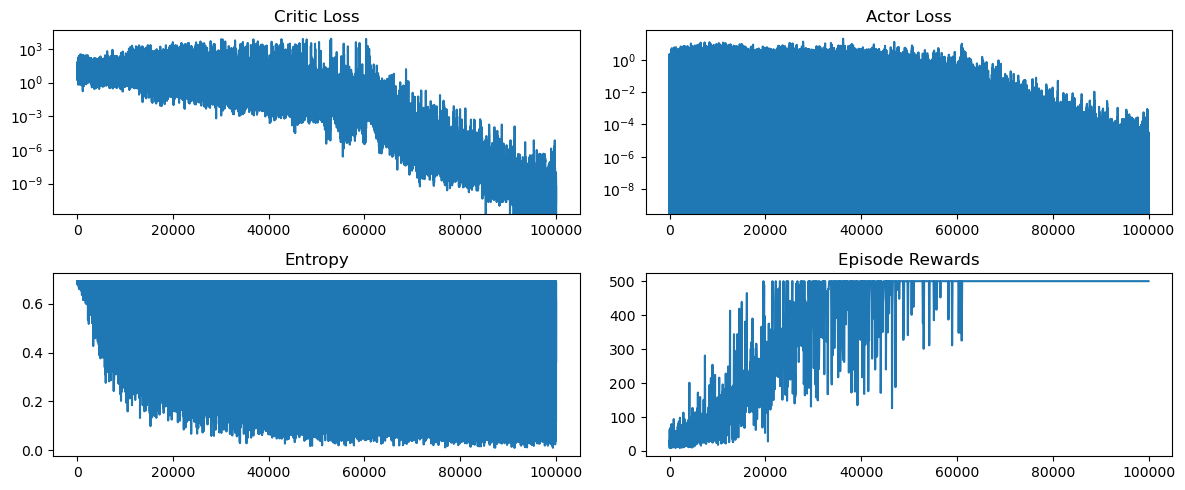

In [114]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
critic_losses = np.array(critic_losses)
capped_loss = critic_losses[critic_losses < 1]
axs[0, 0].plot(critic_losses)
axs[0, 0].set_title('Critic Loss')
axs[0, 0].set_yscale('log')  # Set log scale for the y-axis
axs[0, 1].plot(actor_losses)
axs[0, 1].set_title('Actor Loss')
axs[0, 1].set_yscale('log')  # Set log scale for the y-axis
axs[1, 0].plot(entropies)
axs[1, 0].set_title('Entropy')
axs[1, 1].plot(steps_episodes, episode_returns)
axs[1, 1].set_title('Episode Rewards')
plt.tight_layout()
plt.show()


In [115]:
#save the plot
fig.savefig("A2C_boot.png")

## saving/loading weights

In [9]:
save_weights = True
load_weights = False

actor_weights_path = "weights/actor_weightss.h5"
critic_weights_path = "weights/critic_weightss.h5"

if not os.path.exists("weights"):
    os.mkdir("weights")

""" save network weights """
if save_weights:
    torch.save(agent.actor.state_dict(), actor_weights_path)
    torch.save(agent.critic.state_dict(), critic_weights_path)


""" load network weights """
if load_weights:
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, 1)

    agent.actor.load_state_dict(torch.load(actor_weights_path))
    agent.critic.load_state_dict(torch.load(critic_weights_path))
    agent.actor.eval()
    agent.critic.eval()

## SHOWCASE

In [10]:
n_showcase_episodes = 3

for episode in range(n_showcase_episodes):
    print(f"starting episode {episode}...")

    # create a new sample environment to get new random parameters
    env = gym.make("CartPole-v1", render_mode="human", max_episode_steps=500)

    # get an initial state
    state, info = env.reset()

    # play one episode
    done = False
    while not done:
        # select an action A_{t} using S_{t} as input for the agent
        with torch.no_grad():
            action, _, _, _ = agent.select_action(state[None, :], bool_greedy=True)

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(action.item())

        # update if the environment is done
        done = terminated or truncated

env.close()

starting episode 0...


/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


starting episode 1...
starting episode 2...


: 

### 1.2.1 Printing informations

In [ ]:
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print("------")
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")

NameError: name 'env' is not defined

## 1.3 Define the A2C Class


# 2. Running the Agents (Discrete Case)


A2C.py and then we merge


In [ ]:
from A2C import *

## 1.4 Training function



train.py and then we merge


In [ ]:
from training import *

## 1.5 Evaluation functions

# 2. Running the Agents (Discrete Case)


## 2.1 Agent 1

# 3. Running the Agents (Continuous Case)
